In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

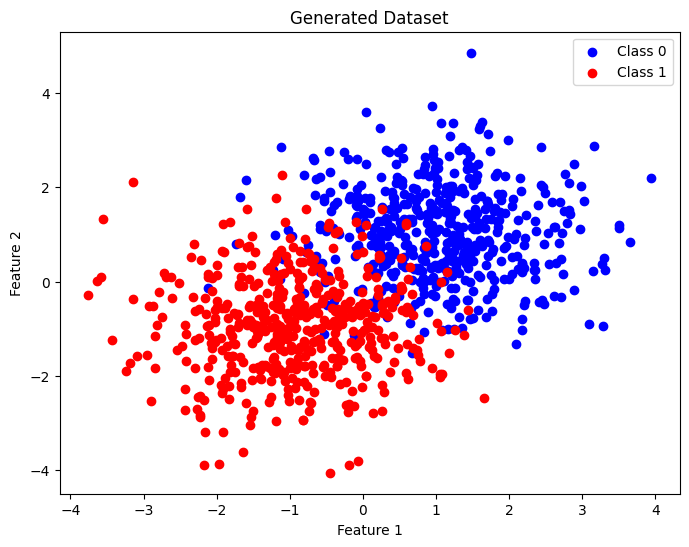

In [12]:
# 设置随机种子保证可重复性
np.random.seed(42)
torch.manual_seed(42)

# 生成人工数据集
def generate_data(n_samples=1000, noise=0.1):
    # 生成两个类别的数据
    X1 = np.random.randn(n_samples//2, 2) + np.array([1, 1])
    X2 = np.random.randn(n_samples//2, 2) + np.array([-1, -1])
    X = np.vstack([X1, X2])
    
    # 添加一些噪声
    X += noise * np.random.randn(*X.shape)
    
    # 创建标签
    y = np.hstack([np.zeros(n_samples//2), np.ones(n_samples//2)])
    
    # 打乱数据
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# 生成并分割数据集
X, y = generate_data(n_samples=1000)
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 可视化数据
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Class 1')
plt.title('Generated Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [3]:
class LogisticRegression:
    def __init__(self, input_dim):
        # 初始化权重和偏置
        self.weights = torch.randn(input_dim, 1, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)
        
    def forward(self, x):
        # 线性变换
        linear = torch.matmul(x, self.weights) + self.bias
        # sigmoid激活函数
        return torch.sigmoid(linear)
    
    def parameters(self):
        return [self.weights, self.bias]
    
    def predict(self, x, threshold=0.5):
        with torch.no_grad():
            proba = self.forward(x)
            return (proba > threshold).float()

In [15]:
def train(model, X, y, epochs=1000, learning_rate=0.1):
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        # 前向传播
        y_pred = model.forward(X)
        
        # 计算损失 - 使用二元交叉熵
        loss = -torch.mean(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred))
        
        # 反向传播
        loss.backward()
        
        # 手动更新参数
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
                param.grad.zero_()
        
        # 记录损失和准确率
        losses.append(loss.item())
        accuracy = torch.mean((model.predict(X) == y).float()).item()
        accuracies.append(accuracy)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    return losses, accuracies

# 初始化模型
model = LogisticRegression(input_dim=2)

# 训练模型
losses, accuracies = train(model, X_train_tensor, y_train_tensor, epochs=1000, learning_rate=0.1)

Epoch 0, Loss: 2.0517, Accuracy: 0.2650
Epoch 100, Loss: 0.2346, Accuracy: 0.9087
Epoch 200, Loss: 0.2031, Accuracy: 0.9212
Epoch 300, Loss: 0.1959, Accuracy: 0.9225
Epoch 400, Loss: 0.1933, Accuracy: 0.9200
Epoch 500, Loss: 0.1921, Accuracy: 0.9200
Epoch 600, Loss: 0.1915, Accuracy: 0.9200
Epoch 700, Loss: 0.1912, Accuracy: 0.9200
Epoch 800, Loss: 0.1910, Accuracy: 0.9200
Epoch 900, Loss: 0.1909, Accuracy: 0.9200


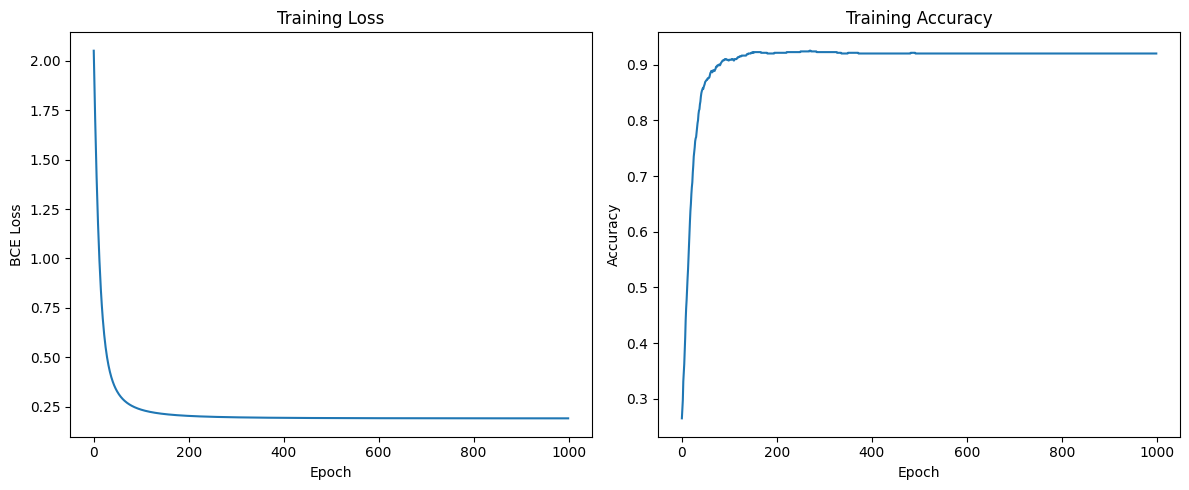

Test Accuracy: 0.9300


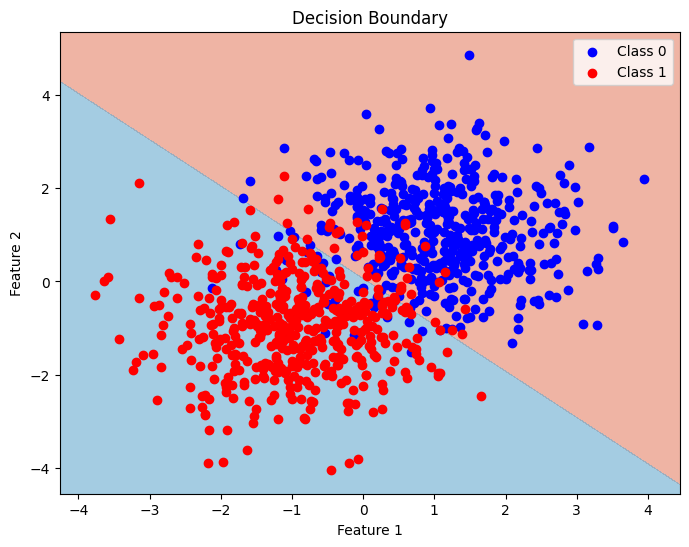

In [16]:
# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 测试集评估
with torch.no_grad():
    test_pred = model.predict(X_test_tensor)
    test_accuracy = torch.mean((test_pred == y_test_tensor).float()).item()
    print(f'Test Accuracy: {test_accuracy:.4f}')

# 可视化决策边界
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model.forward(X_grid).numpy().reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
    plt.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Class 1')
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_decision_boundary(model, X, y)